# Fáza 2 - Predspracovanie údajov

__Autori:__ Dávid Penťa, Samuel Bernát
__Percentuálny podiel práce:__ 50% / 50%

V tejto fáze sa od Vás očakáva že realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada (csv alebo tsv), kde jedno pozorovanie je opísané jedným riadkom.
- scikit-learn vie len numerické dáta, takže treba niečo spraviť s nenumerickými dátami.
- Replikovateľnosť predspracovania na trénovacej a testovacej množine dát, aby ste mohli
zopakovať predspracovanie viackrát podľa Vašej potreby (iteratívne).

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát, je možné že treba realizovať EDA opakovane podľa Vašej potreby. Bodovanie znovu (EDA) nebudeme, zmeny ale dokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa potreby.

In [37]:
import statsmodels.api as sm
import dateparser as dateparser
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.stats.api as sms
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import pearsonr
import math
from matplotlib import pyplot
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from operator import itemgetter

In [38]:
measurements_file = "data/measurements.csv"
measurements_data = pd.read_csv(measurements_file, sep='\t')

stations_file = "data/stations.csv"
stations_data = pd.read_csv(stations_file, sep='\t')

## Integrácia a čistenie dát
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte.
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie ako napr.
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

In [39]:
measurements_data.dropna(inplace=True)
stations_data.dropna(inplace=True)

stations_data["QoS"] = np.where(stations_data["QoS"] == "accep", "acceptable", stations_data["QoS"])
stations_data["QoS"] = np.where(stations_data["QoS"] == "maitennce", "maintenance", stations_data["QoS"])

# stations_data['revision'] = stations_data['revision'].apply(lambda x: pd.Timestamp(x).strftime('%B-%d-%Y'))
# stations_data['revision_timestamp'] = stations_data['revision'].apply(lambda x: pd.Timestamp(x).timestamp())
stations_data['revision'] = stations_data['revision'].apply(lambda x: pd.Timestamp(x).timestamp())

stations_data['latitude'] = stations_data['latitude'].round(5)
stations_data['longitude'] = stations_data['longitude'].round(5)

stations_data["station"] = np.where(stations_data["station"] == "T‚Äôaebaek", "Taebaek", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "'Ali Sabieh", "Ali Sabieh", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Oktyabr‚Äôskiy", "Oktyabrsk", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Roslavl‚Äô", "Roslavl", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Dyat‚Äôkovo", "Dyatkovo", stations_data["station"])

stations_data

,QoS,station,code,latitude,longitude,revision
0,good,Casa Blanca,MX,19.04222,-98.11889,1.574813e+09
1,building,Mikhaylovka,RU,50.06000,43.23790,1.501027e+09
2,building,Shahre Jadide Andisheh,IR,35.68030,51.01930,1.370045e+09
3,building,Aracaju,BR,-10.91111,-37.07167,1.356739e+09
4,maintenance,Parola,IN,20.88098,75.11937,1.562285e+09
...,...,...,...,...,...,...
1105,building,Tadmur,SY,34.56240,38.28402,1.373414e+09
1106,average,Jizzax,UZ,40.11583,67.84222,1.369872e+09
1107,acceptable,West Chester,US,39.96097,-75.60804,1.351987e+09
1108,acceptable,Oktyabrsk,RU,54.48147,53.47103,1.429315e+09


In [40]:
stations_data = stations_data.groupby(by='station').apply(lambda x: x.loc[x['revision']==x['revision'].max()])

## Spojenie tabuliek

In [41]:
df=pd.merge(stations_data, measurements_data, on=['latitude', 'longitude'], how='inner')

df

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,O3,TEMP,NOx,SO2,NH3,CH4,PRES,PM2.5,warning,PAHs
0,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.94040,8.15390,51.70980,1.07014,...,7.59161,6.60825,7.42432,8.52814,10.37150,8.04118,1113.51031,8.45419,0.0,7.47770
1,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,9.92679,7.48092,50.20703,2.64911,...,7.63081,6.16413,8.41506,8.10514,8.64142,5.75635,1141.89103,8.98874,0.0,5.31318
2,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,7.70897,7.94669,30.48851,0.46590,...,9.90479,7.45631,6.88163,8.67120,7.16353,8.02152,1141.32144,8.99272,0.0,5.60567
3,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.79345,7.95665,41.96855,0.91801,...,7.43302,11.97880,9.63301,8.68320,8.31095,8.63908,1051.38525,10.07743,0.0,6.80804
4,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.19808,7.87163,25.72025,0.59423,...,5.30181,2.99136,8.13061,9.95595,5.97990,6.37283,1153.65647,9.25494,0.0,7.14369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11339,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.89369,7.75732,43.95104,1.05577,...,7.89935,13.31804,7.97301,6.95242,9.15684,6.94692,1096.63218,7.71518,1.0,9.12317
11340,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,7.15250,6.64782,56.67238,0.26810,...,5.92714,2.83320,8.14658,5.88350,4.17718,6.40035,1181.06702,10.33065,0.0,8.77173
11341,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.65674,5.70363,61.58862,0.78845,...,9.56202,4.47710,6.67552,8.31503,9.23302,7.91515,1077.81115,9.00477,0.0,8.22518
11342,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,6.27031,4.97595,49.20954,0.25750,...,6.13673,3.79766,8.25153,9.35591,4.62164,6.27290,1081.73222,9.73974,1.0,9.26331


### Opis každého atribútu numerickým formátom

In [42]:
df['QoS_ID'] = -1

df.loc[df.QoS == "excellent", "QoS_ID"] = "1"
df.loc[df.QoS == "good", "QoS_ID"] = "2"
df.loc[df.QoS == "average", "QoS_ID"] = "3"
df.loc[df.QoS == "acceptable", "QoS_ID"] = "4"
df.loc[df.QoS == "building", "QoS_ID"] = "5"
df.loc[df.QoS == "maintenance", "QoS_ID"] = "5"

df[['QoS_ID']] = df[['QoS_ID']].apply(pd.to_numeric)

In [43]:
df['station_ID'] = df['station'].rank(method='dense')
df['code_ID'] = df['code'].rank(method='dense')

df

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,SO2,NH3,CH4,PRES,PM2.5,warning,PAHs,QoS_ID,station_ID,code_ID
0,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.94040,8.15390,51.70980,1.07014,...,8.52814,10.37150,8.04118,1113.51031,8.45419,0.0,7.47770,5,1.0,38.0
1,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,9.92679,7.48092,50.20703,2.64911,...,8.10514,8.64142,5.75635,1141.89103,8.98874,0.0,5.31318,5,1.0,38.0
2,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,7.70897,7.94669,30.48851,0.46590,...,8.67120,7.16353,8.02152,1141.32144,8.99272,0.0,5.60567,5,1.0,38.0
3,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.79345,7.95665,41.96855,0.91801,...,8.68320,8.31095,8.63908,1051.38525,10.07743,0.0,6.80804,5,1.0,38.0
4,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.19808,7.87163,25.72025,0.59423,...,9.95595,5.97990,6.37283,1153.65647,9.25494,0.0,7.14369,5,1.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11339,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.89369,7.75732,43.95104,1.05577,...,6.95242,9.15684,6.94692,1096.63218,7.71518,1.0,9.12317,1,661.0,1.0
11340,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,7.15250,6.64782,56.67238,0.26810,...,5.88350,4.17718,6.40035,1181.06702,10.33065,0.0,8.77173,1,661.0,1.0
11341,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.65674,5.70363,61.58862,0.78845,...,8.31503,9.23302,7.91515,1077.81115,9.00477,0.0,8.22518,1,661.0,1.0
11342,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,6.27031,4.97595,49.20954,0.25750,...,9.35591,4.62164,6.27290,1081.73222,9.73974,1.0,9.26331,1,661.0,1.0


### Uloženie upravenej dátovej sady do .csv súboru

In [44]:
output = df[['station_ID', 'code_ID', 'QoS_ID', 'warning', 'latitude', 'longitude', 'revision','PAHs', 'PM10', 'CO', 'Pb', 'C2H3NO5', 'CFCs', 'H2CO', 'O3', 'TEMP', 'NOx', 'SO2', 'NH3', 'CH4', 'PRES', 'PM2.5']]

output.to_csv('output.csv', index=False)

### Power Transformer

In [45]:
def transform(column_name):

    sns.histplot(data=df, hue='warning', x=column_name, fill=True, kde=True)
    plt.show()

    data = df[column_name].values
    data = data.reshape((len(data),1))

    power = PowerTransformer(
                method='yeo-johnson',
                standardize=True)
    data_trans = power.fit_transform(data)
    df[column_name] = data_trans

    sns.histplot(data=df, hue='warning', x=column_name, fill=True, kde=True)
    plt.show()

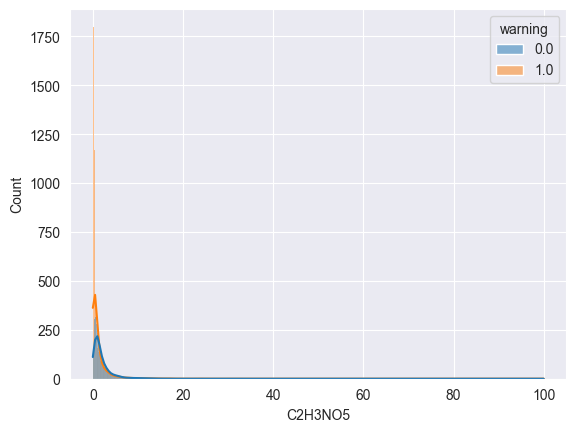

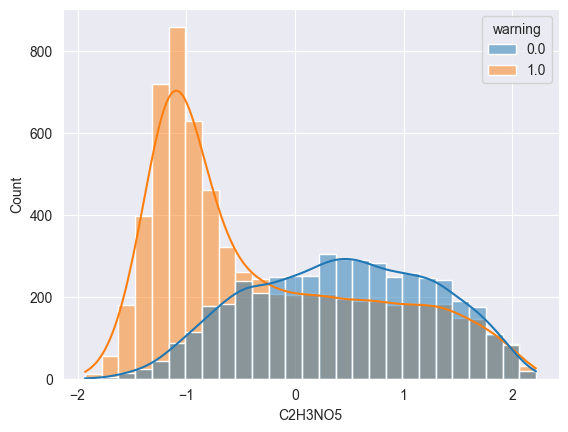

In [46]:
transform('C2H3NO5')

# arr_0 = ['PAHs', 'PM10', 'CO', 'Pb', 'C2H3NO5', 'CFCs', 'H2CO', 'O3', 'TEMP', 'NOx', 'SO2', 'NH3', 'CH4', 'PRES', 'PM2.5']
# for i in arr_0:
#     print(i)
#     transform(i)

### Zoradenie podla p a zaroven r

In [47]:
arr = []
#
for i in list(df.columns.values):
    if i != 'QoS' and i != 'station' and i != 'code':
        (r, p) = pearsonr(df['warning'], df[i])
        if p < 0.05 and i != 'warning':
            arr.append([i, abs(r), p])

arr = sorted(arr, key=itemgetter(1))
a = []
for i in range(len(arr)):
    a.append([i + 1, arr[len(arr) - i - 1][0], arr[len(arr) - i - 1][1], arr[len(arr) - i - 1][2]])

for row in a:
    print("{: >0} {: >10} {:.5f} {:.5f}".format(*row))

1       PAHs 0.63745 0.00000
2       PM10 0.38176 0.00000
3    C2H3NO5 0.35502 0.00000
4        NH3 0.33896 0.00000
5        CH4 0.33534 0.00000
6      PM2.5 0.02611 0.00542
7       H2CO 0.01939 0.03889
